# Extracting Information from Text

本章的目標是回答以下問題:

1. 如何從無結構的文字中取出結構化的資料?
2. 有那些方法可辨識文字中描述的實體和關係?
3. 有那些corpora適合作這件事，如何用它們來訓練和評估?

## Information Extraction

假設我們能從文字中找出`(entity, relation, entity)`這樣的關係，就能回答許多問題。例如，我們想知道文中的那家公司位於紐約:

In [3]:
location = [('Omnicom','IN','New York'), ('DBB','IN','New York'), ('BBDO','IN','Atlanta')]
[e1 for (e1, rel, e2) in location if rel == 'IN' and e2 == 'New York']

['Omnicom', 'DBB']

In [1]:
import nltk
from nltk.corpus import ieer

一般的information extraction分為幾個步驟

1. 輸入raw text，進行sentence segmentation
2. 輸入sentence，進行tokenization
3. 輸入list of words，進行part of speech tagging
4. 輸入list of tuples，進行entity recognition
5. 輸入list of trees，進行relation recognition

前面三個步驟不是本章的重點，因此將三個步驟結合成一個function。接下來要找出proper names(專有名詞)或是definite noun phrases(指示名詞)，作為entity的可能候選。最後，再成對的entity中找出relation的可能pattern。

In [66]:
def preprocess(document, tagset="universal"):
    sent = nltk.sent_tokenize(document)
    sent = [nltk.word_tokenize(s) for s in sent]
    sent = [nltk.pos_tag(s, tagset=tagset) for s in sent]
    return sent

## Chunking

要辨識entity最基本的技巧稱為chunking，我們會將多個單字結合起來成為一個**chunk**，這個過程稱為noun phrase chunking或NP-chunking。

In [3]:
sentence = preprocess('the little yellow dog barked at the cat')[0]
sentence

[('the', u'DET'),
 ('little', u'ADJ'),
 ('yellow', u'ADJ'),
 ('dog', u'NOUN'),
 ('barked', u'VERB'),
 ('at', u'ADP'),
 ('the', u'DET'),
 ('cat', u'NOUN')]

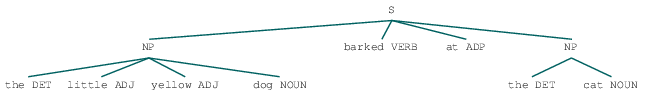

In [4]:
# RegexpParser: 將符合條件的POS組合成一個新的
grammar = "NP: {<DET>?<ADJ>*<NOUN>}"
cp = nltk.RegexpParser(grammar)
cp.parse(sentence)

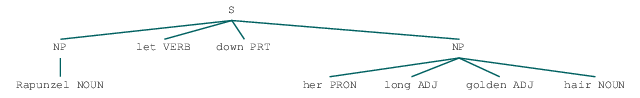

In [5]:
# 改良版的規則
#   (冠詞|所有格) + 形容詞 + 名詞，如"The black fat cat"
#   連續的專有名詞，如"Mary Brown"
grammar = r"""
    NP: {<DET|PRON>?<ADJ>*<NOUN>}
        {<NOUN>+}
"""
cp = nltk.RegexpParser(grammar)
sentence = preprocess("Rapunzel let down her long golden hair")[0]
cp.parse(sentence)

## Exploring Text Corpora

一種chunking的應用，是從corpus中，找出特定詞性組合的字。例如want to buy是VERB-PRT-VERB，或連續四個名詞的組合。

In [6]:
def find_chunks(user_rule = '{<V.*><TO><V.*>}'):
    cp = nltk.RegexpParser('CHUNK: ' + user_rule)
    for sent in nltk.corpus.brown.tagged_sents():
        tree = cp.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == 'CHUNK':
                yield subtree

In [7]:
v_to_v = list(find_chunks())

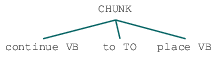

In [8]:
v_to_v[1]

In [9]:
n4 = list(find_chunks('{<N.*><N.*><N.*><N.*>+}'))

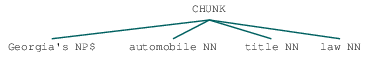

In [10]:
n4[2]

## Chinking

另一種作chunking的方法是反向定義，定義那些部分不要放入chunk，這些部分稱為**chink**。

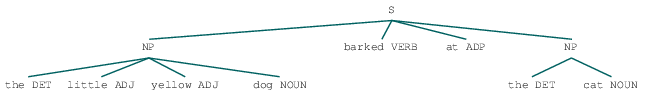

In [11]:
grammar = r"""
    NP: {<.*>+}      # chunk everything
        }<VERB|ADP>+{  # chink sequence of VBD and IN
"""
sentence = preprocess('the little yellow dog barked at the cat')[0]
cp = nltk.RegexpParser(grammar)
cp.parse(sentence)

## Developing and Evaluating Chunkers

chunk結構有一種慣用的tagging，稱為**IOB tags**。所有的字分為三種: I(在chunk內)、O(在chunk外)、B(chunk開頭)，通常B和I後面會接上chunk的名稱，例如B-NP或I-NP。

要對chunking演算法作出評分，我們需要training data，最常用的training data格式稱為CoNLL，每一行有三個元素，第一個是token，第二個是詞性，第三個是IOB tag。使用`conllstr2tree`可以將這種格式的檔案轉換為樹狀結構。

In [12]:
conll_example = '''
he PRP B-NP
accepted VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chairman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''

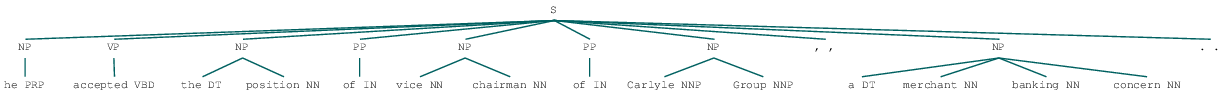

In [13]:
nltk.chunk.conllstr2tree(conll_example)

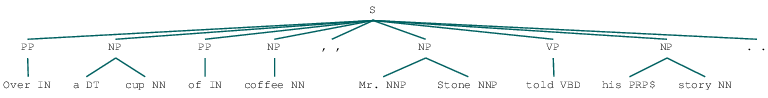

In [14]:
# conll2000是來自Wall Street Journal的文字，已經標註IOB tags
from nltk.corpus import conll2000
conll2000.chunked_sents()[99]

在conll2000中，有三種類型的chunk: NP chunks(例如the black dog)、VP chunks(例如has already known)、PP chunks(例如because of)。如果對於NP chunks比較有興趣，可以指定要看的chunk種類:

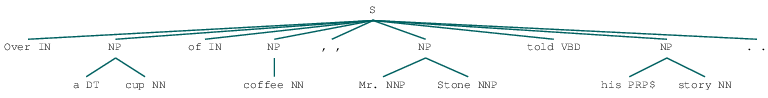

In [15]:
conll2000.chunked_sents(chunk_types=['NP'])[99]

In [16]:
# 已經有分為兩個資料集了
conll2000.fileids()

['train.txt', 'test.txt']

In [17]:
# 先用空的parser試試看
cp = nltk.RegexpParser("")
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
print cp.evaluate(test_sents)

ChunkParse score:
    IOB Accuracy:  43.4%
    Precision:      0.0%
    Recall:         0.0%
    F-Measure:      0.0%


因為空的parser不會標註任何資料，遇到NP以外的地方就是對的，至少還有43%的正確率。

但因為完全沒有true positive，precision及recall都是0。

In [18]:
# 嘗試用最簡單的parser
grammar = r"NP: {<[CDJNP].*>+}"
cp = nltk.RegexpParser(grammar)
print cp.evaluate(test_sents)

ChunkParse score:
    IOB Accuracy:  87.7%
    Precision:     70.6%
    Recall:        67.8%
    F-Measure:     69.2%


如果要自己設計chunker，可以用一個class繼承`nltk.ChunkParserI`，並且實作`__init__`及`parse`這兩個function。例如下面用unigram model來實作chunker:

In [20]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        """
        train_sents: 傳進來的training data，必須是chunk tree的形式
        """
        # 經過tree2conlltags轉換後，變成tuple (word, pos_tag, chunk_tag)
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        # 根據pos_tag預測chunk_tag
        self.tagger = nltk.UnigramTagger(train_data)
    
    def parse(self, sentence):
        """
        sentence: (word, pos)組成的句子
        return: conll tree
        """
        pos_tags = [pos for word, pos in sentence]
        # 根據pos_tag預測chunk_tag，不需其他資訊
        iob_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for pos, chunktag in iob_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [21]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
unigram_chunker = UnigramChunker(train_sents)
print unigram_chunker.evaluate(test_sents)

ChunkParse score:
    IOB Accuracy:  92.9%
    Precision:     79.9%
    Recall:        86.8%
    F-Measure:     83.2%


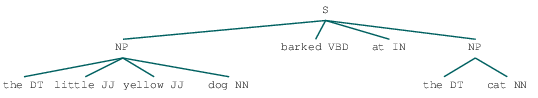

In [29]:
# 前面preprocess是採用universal tag
# 但這裡訓練時，因為不是用universal tag，所以第二個參數要給空字串
sentence = preprocess('the little yellow dog barked at the cat', '')[0]
unigram_chunker.parse(sentence)

## Training Classifier-Based Chunkers

regular expression chunker及n-gram chunker都是依賴POS tag來判斷，但有些情況會失準。  
例如: `Joey/NN sold/VBD the/DT farmer/NN rice/NN ./.`  
這裡的the farmer rice應該分成"the farmer"及"rice"，但用POS判斷，則會視為"the farmer rice"。

下面會示範如何將chunker延伸成classifier。

In [40]:
# 這是一個conll tree的樣子
print train_sents[99]

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


In [41]:
# 這是將conll tree轉換成tuple的樣子，也是我們訓練資料的格式
nltk.chunk.tree2conlltags(train_sents[99])

[(u'Over', u'IN', u'O'),
 (u'a', u'DT', u'B-NP'),
 (u'cup', u'NN', u'I-NP'),
 (u'of', u'IN', u'O'),
 (u'coffee', u'NN', u'B-NP'),
 (u',', u',', u'O'),
 (u'Mr.', u'NNP', u'B-NP'),
 (u'Stone', u'NNP', u'I-NP'),
 (u'told', u'VBD', u'O'),
 (u'his', u'PRP$', u'B-NP'),
 (u'story', u'NN', u'I-NP'),
 (u'.', u'.', u'O')]

In [42]:
def npchunk_features(sentence, i, history):
    """
    第一步，先定義feature
    這裡先用與unigram chunker完全相同的feature，這樣才能確定classifier是否正確
    如果classifier正確，則結果應該與unigram chunker差不多
    
    sentence -- 需要提取feature的句子，格式為list of (word, pos_tag)
    i -- 目前是句子的第幾個字
    history -- 前面的單字對應的tags
    """
    word, pos = sentence[i]
    return {"pos": pos}

In [58]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):
    """
    第二步，定義一個接受training data並訓練出classifier的class
    """
    def __init__(self, train_sents):
        """輸入訓練用的句子，得到一個Maxent Classifier
        train_sents -- list of list of ((word, pos_tag), chunk_tag)
        """
        train_set = []
        for tagged_sent in train_sents:
            # tagged_sent -- list of ((word, pos_tag), chunk_tag)
            # untagged_sent -- list of (word, pos_tag)
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (_, chunk_tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                # 產生feature sets及IOB tag的對應關係，存到train_set
                train_set.append( (featureset, chunk_tag) )
                history.append(chunk_tag)
        # 利用MaxentClassifier學習featureset與tag的對應關係
        self.classifier = nltk.MaxentClassifier.train(train_set, algorithm='iis', trace=0)
        
    def tag(self, sentence):
        """輸入要作chunk tagging的句子
        sentence -- list of (word, pos_tag)
        """
        history = []
        for i, _ in enumerate(sentence):
            # 產生句子對應的feature set
            featureset = npchunk_features(sentence, i, history)
            # 將feature set丟進classifier找出tag
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

In [49]:
class ConsecutiveNPChunker(nltk.ChunkParserI):
    """
    第三步，單純定義一個介面，將conll tree格式的句子轉換成((word, pos_tag), chunk_tag)
    並丟給ConsecutiveNPChunkTagger訓練出classifier
    """
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [50]:
chunker = ConsecutiveNPChunker(train_sents)

<ChunkScoring of 12422 chunks>

In [52]:
# 因為feature完全與unigram相同，所以結果也相同
print chunker.evaluate(test_sents)

ChunkParse score:
    IOB Accuracy:  92.9%
    Precision:     79.9%
    Recall:        86.8%
    F-Measure:     83.2%


嘗試第二個版本的feature set，將前一個tag加入feature:

In [53]:
def npchunk_features(sentence, i, history):
    """
    sentence -- 需要提取feature的句子，格式為list of (word, pos_tag)
    i -- 目前是句子的第幾個字
    history -- 前面的單字對應的tags
    """
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    return {"pos": pos, "prevpos": prevpos}

In [59]:
chunker = ConsecutiveNPChunker(train_sents)

In [60]:
print chunker.evaluate(test_sents)

ChunkParse score:
    IOB Accuracy:  93.6%
    Precision:     82.0%
    Recall:        87.2%
    F-Measure:     84.6%


嘗試第三個版本的feature set，將目前的單字加入feature。

In [61]:
def npchunk_features(sentence, i, history):
    """
    sentence -- 需要提取feature的句子，格式為list of (word, pos_tag)
    i -- 目前是句子的第幾個字
    history -- 前面的單字對應的tags
    """
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    return {"pos": pos, "word": word, "prevpos": prevpos}

In [62]:
chunker = ConsecutiveNPChunker(train_sents)

In [63]:
print chunker.evaluate(test_sents)

ChunkParse score:
    IOB Accuracy:  94.6%
    Precision:     84.6%
    Recall:        89.8%
    F-Measure:     87.1%


最後一個版本，加入後一個字的tag、前後pos的關聯、及冠詞後面的tag。

In [64]:
def tags_since_dt(sentence, i):
    tags = set()
    for word, pos in sentence[:i]:
        if pos == 'DT':
            tags = set()
        else:
            tags.add(pos)
    return '+'.join(sorted(tags))

def npchunk_features(sentence, i, history):
    """
    sentence -- 需要提取feature的句子，格式為list of (word, pos_tag)
    i -- 目前是句子的第幾個字
    history -- 前面的單字對應的tags
    """
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, nextpos = sentence[i+1]
    return {"pos": pos, "word": word, "prevpos": prevpos, "nextpos": nextpos,
            "prevpos+pos": "%s+%s" % (prevpos, pos),
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            "tags-since-dt": tags_since_dt(sentence, i)}

In [65]:
chunker = ConsecutiveNPChunker(train_sents)

In [67]:
print chunker.evaluate(test_sents)

ChunkParse score:
    IOB Accuracy:  96.0%
    Precision:     88.3%
    Recall:        91.1%
    F-Measure:     89.7%


## Recursion in Linguistic Structure

在regular expression chunker中，如果grammar包含四種不同的chunk規則，則chunk tree的深度最多為四層。

In [79]:
grammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """
cp = nltk.RegexpParser(grammar)
sentence = "Mary saw the cat sit on the mat"
preprocess(sentence, "")

[[('Mary', 'NNP'),
  ('saw', 'VBD'),
  ('the', 'DT'),
  ('cat', 'NN'),
  ('sit', 'NN'),
  ('on', 'IN'),
  ('the', 'DT'),
  ('mat', 'NN')]]

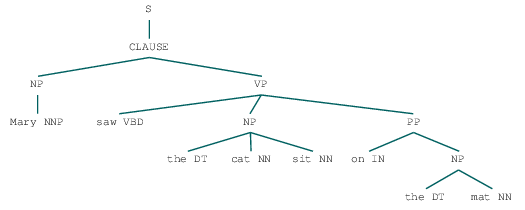

In [80]:
# 這個句子沒問題
cp.parse(preprocess(sentence, "")[0])

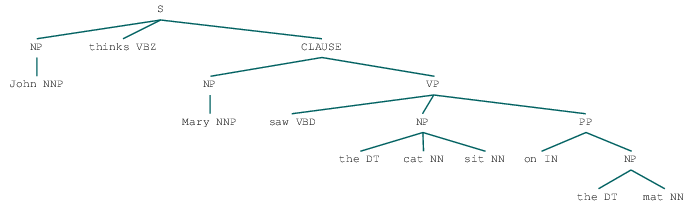

In [82]:
# 但加上子句後就有問題，thinks沒有正確處理
sentence = "John thinks Mary saw the cat sit on the mat"
cp.parse(preprocess(sentence, "")[0])

在上面的例子中，因為加上John thinks導致層數變多，所以thinks就被錯誤處理，沒有合併成VP。這可以用`loop=2`的參數來解決。

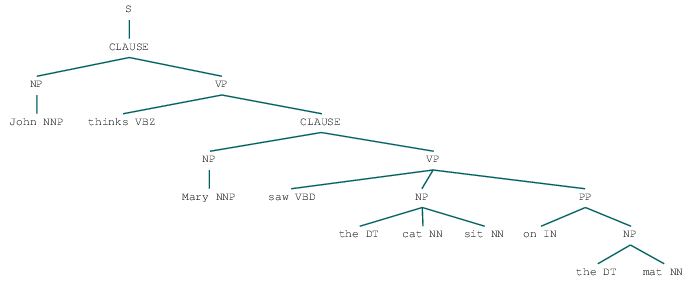

In [83]:
cp = nltk.RegexpParser(grammar, loop=2)
cp.parse(preprocess(sentence, "")[0])

## Named Entity Recognition

當我們能夠正確辨識出NP chunk後，下一步就是辨識那個NP chunk屬於named entity，這個過程稱為NER(named  entity recognition)。

named entity(NE)有以下類型:
* ORGANIZATION: Georgia-Pacific Corp., WHO
* PERSON: Eddy Bonte, President Obama
* LOCATION: Murray River, Mount Everest
* DATE: June, 2008-06-29
* TIME: two fifty a m, 1:30 p.m.
* MONEY: 175 million Canadian Dollars, GBP 10.40
* PERCENT: twenty pct, 18.75 %
* FACILITY: Washington Monument, Stonehenge
* GPE: South East Asia, Midlothian

NER問題的困難點

1. 人名或組織名更新太快，缺少dictionary可以用查表的方法解決
2. 有些名稱同時屬於不同類型的NE，例如May同時是地名也是日期，也可以是人名
3. 多字組成的名詞，需要辨識起始和結束位置

在conll2002的資料集中，就有包含NER問題的訓練資料。

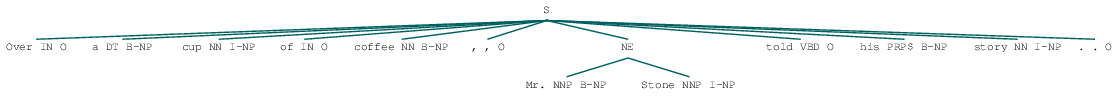

In [89]:
# 使用binary=True，只會標註NE的位置，但不會標註類型
nltk.ne_chunk(nltk.chunk.tree2conlltags(train_sents[99]), binary=True)

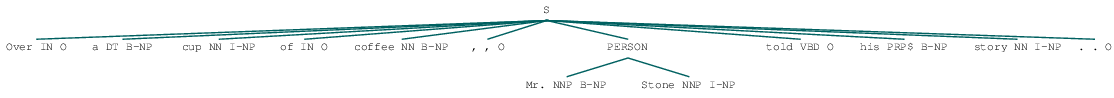

In [91]:
# 不使用binary=True，會標註類型 (例如PERSON)
nltk.ne_chunk(nltk.chunk.tree2conlltags(train_sents[99]))

## Relation Extraction

當所有NE都辨識出來後，就可以試著找它們之間的關係，並輸出為(X, relation, Y)的形式。下面以regular expression為例，示範如何使用relation extration。

In [95]:
import re
IN = re.compile(r'.*\bin\b(?!\b.+ing)')
for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
     for rel in nltk.sem.extract_rels('ORG', 'LOC', doc, corpus='ieer', pattern = IN):
            print nltk.sem.rtuple(rel)

[ORG: u'WHYY'] u'in' [LOC: u'Philadelphia']
[ORG: u'McGlashan &AMP; Sarrail'] u'firm in' [LOC: u'San Mateo']
[ORG: u'Freedom Forum'] u'in' [LOC: u'Arlington']
[ORG: u'Brookings Institution'] u', the research group in' [LOC: u'Washington']
[ORG: u'Idealab'] u', a self-described business incubator based in' [LOC: u'Los Angeles']
[ORG: u'Open Text'] u', based in' [LOC: u'Waterloo']
[ORG: u'WGBH'] u'in' [LOC: u'Boston']
[ORG: u'Bastille Opera'] u'in' [LOC: u'Paris']
[ORG: u'Omnicom'] u'in' [LOC: u'New York']
[ORG: u'DDB Needham'] u'in' [LOC: u'New York']
[ORG: u'Kaplan Thaler Group'] u'in' [LOC: u'New York']
[ORG: u'BBDO South'] u'in' [LOC: u'Atlanta']
[ORG: u'Georgia-Pacific'] u'in' [LOC: u'Atlanta']
